In [40]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import seaborn as sns

In [2]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names= ["Model","No of Hidden Layers","No of Units","Accuracy"]
print(table)

+-------+---------------------+-------------+----------+
| Model | No of Hidden Layers | No of Units | Accuracy |
+-------+---------------------+-------------+----------+
+-------+---------------------+-------------+----------+


In [41]:
mnist_data = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [42]:
print("number of data points : ", mnist_data.train.images.shape[0],
      "number of pixels in each image :",mnist_data.train.images.shape[1])

number of data points :  55000 number of pixels in each image : 784


In [43]:
# Get a list of devices like GPUs and CPUs available to TF

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12397839269985006041
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17473238461952891567
physical_device_desc: "device: XLA_CPU device"
]


In [44]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
def plt_dynamic(x, y, y_1, ax, ticks, fig, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
    fig.canvas.draw()

In [45]:
# Parameters
training_epochs = 15
learning_rate = 0.001
batch_size = 100
display_step = 1

In [46]:
# 2 Layer MLP 

In [79]:
# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [89]:
x = tf.placeholder(tf.float32, [None, n_input])
y_ = tf.placeholder(tf.float32, [None, n_classes])

# keep_prob: we will be using these placeholders when we use dropouts, 
# while testing model
keep_prob = tf.placeholder(tf.float32)
# keep_prob_input: we will be using these placeholders when we use dropouts,
# while training model
keep_prob_input = tf.placeholder(tf.float32)

In [81]:
# Weight initialization
# He Normal initialization.
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],
                            stddev=(2/(n_hidden_1+1))**0.5, mean=0)),
    
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],
                            stddev=(2/(n_hidden_2+1))**0.5, mean=0)),
    
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],
                            stddev=(2/(n_classes+1))**0.5, mean=0))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [82]:
# Model 1
use_batchNorm, use_dropOut = True, True   # WE have to keep changing these switches
epsilon = 1e-3

print( 'x:', x.get_shape(), 'W[h1]:', weights_relu['h1'].get_shape(), 
                              'b[h1]:', biases['b1'].get_shape())

# Hidden layer with Relu activation
layer_1 = tf.add(tf.matmul(x, weights_relu['h1']), biases['b1'])    

if use_batchNorm:
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, 
                                        beta_1, scale_1, epsilon)
layer_1 = tf.nn.relu(layer_1)
if use_dropOut:
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    
print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights_relu['h2'].get_shape(),
                              'b[h2]:', biases['b2'].get_shape()) 

# Hidden layer with Relu activation
layer_2 = tf.add(tf.matmul(layer_1, weights_relu['h2']), biases['b2'])
if use_batchNorm:
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, 
                                        beta_2, scale_2, epsilon)

layer_2 = tf.nn.relu(layer_2)
if use_dropOut:
    layer_2 = tf.nn.dropout(layer_2, keep_prob)
    
print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights_relu['out'].get_shape(),
                              'b3:', biases['out'].get_shape())

# Output layer with Sigmoid activation
out_layer = tf.matmul(layer_2, weights_relu['out']) + biases['out']
out_layer = tf.nn.sigmoid(out_layer)
print('out_layer:',out_layer.get_shape())

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 256) b[h2]: (256,)
layer_2: (?, 256) W[out]: (256, 10) b3: (10,)
out_layer: (?, 10)


In [47]:
# set up cost and optimizer

cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = out_layer, labels = y_))
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

In [48]:
def run_model():
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        fig,ax = plt.subplots(1,1)
        ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
        xs, ytrs, ytes = [], [], []
        for epoch in range(training_epochs):
            train_avg_cost = 0.
            test_avg_cost = 0.
            total_batch = int(mnist_data.train.num_examples/batch_size)

            # Loop over all batches
            for i in range(total_batch):
                batch_xs, batch_ys = mnist_data.train.next_batch(batch_size)

                # here we use AdamOptimizer
                _, c, w = sess.run([optimizer_adam, cost_sgd,weights_relu], 
                                   feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
                train_avg_cost += c / total_batch
                c = sess.run(cost_sgd, feed_dict={x: mnist_data.test.images, 
                                              y_: mnist_data.test.labels,  keep_prob: 1.0})
                test_avg_cost += c / total_batch

            xs.append(epoch)
            ytrs.append(train_avg_cost)
            ytes.append(test_avg_cost)
            plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),fig, 
                            "input-relu(256)-relu(256)-sigmoid(output)-AdamOptimizer")

            if epoch%display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost),
                                                  "test cost={:.9f}".format(test_avg_cost))
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),fig,
                            "input-relu(256)-relu(256)-sigmoid(output)-AdamOptimizer")

        # we are calculating the final accuracy on the test data
        correct_prediction = tf.equal(tf.argmax(out_layer,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print("Accuracy:", accuracy.eval({x: mnist_data.test.images, 
                                  y_: mnist_data.test.labels, keep_prob: 1.0}))
        return w, c

Epoch: 0001 train cost=1.638137851 test cost=1.634130663
Epoch: 0002 train cost=1.579409492 test cost=1.581957993
Epoch: 0003 train cost=1.569017958 test cost=1.573428834
Epoch: 0004 train cost=1.564145212 test cost=1.569962316
Epoch: 0005 train cost=1.561130864 test cost=1.568191827
Epoch: 0006 train cost=1.558779271 test cost=1.566803451
Epoch: 0007 train cost=1.556484338 test cost=1.565923119
Epoch: 0008 train cost=1.555649045 test cost=1.565952892
Epoch: 0009 train cost=1.554709715 test cost=1.565424182
Epoch: 0010 train cost=1.554094869 test cost=1.564856987
Epoch: 0011 train cost=1.553592909 test cost=1.564700108
Epoch: 0012 train cost=1.553080339 test cost=1.564989796
Epoch: 0013 train cost=1.552461133 test cost=1.564709585
Epoch: 0014 train cost=1.527282557 test cost=1.538429071
Epoch: 0015 train cost=1.472550573 test cost=1.483117800
Accuracy: 0.9757


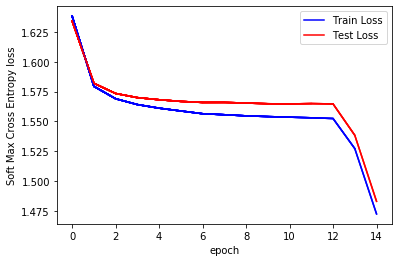

In [15]:
# Without BN and Dropout
w,c = run_model()

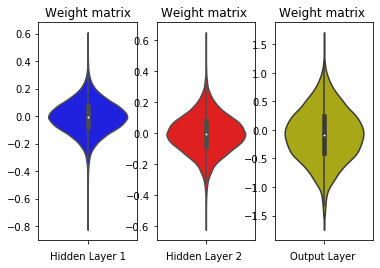

In [16]:
# Plot weight distriubtion at the end of training.
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)

fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

In [18]:
# "Model","No of Layers","No of Units","Activation","Accuracy"
table.add_row(["No BN & No Dropout",2,"[784,256,256,10]",0.97])
print(table)

+--------------------+---------------------+------------------+----------+
|       Model        | No of Hidden Layers |   No of Units    | Accuracy |
+--------------------+---------------------+------------------+----------+
| No BN & No Dropout |          2          | [784,256,256,10] |   0.97   |
+--------------------+---------------------+------------------+----------+


Epoch: 0001 train cost=1.558521085 test cost=1.549814029
Epoch: 0002 train cost=1.494003643 test cost=1.494502273
Epoch: 0003 train cost=1.484580707 test cost=1.487758414
Epoch: 0004 train cost=1.479685761 test cost=1.484713249
Epoch: 0005 train cost=1.476566528 test cost=1.483627151
Epoch: 0006 train cost=1.474599217 test cost=1.481932188
Epoch: 0007 train cost=1.472807444 test cost=1.481972849
Epoch: 0008 train cost=1.471720335 test cost=1.481531454
Epoch: 0009 train cost=1.471059687 test cost=1.480596901
Epoch: 0010 train cost=1.469470541 test cost=1.479541919
Epoch: 0011 train cost=1.468687457 test cost=1.479752764
Epoch: 0012 train cost=1.468454835 test cost=1.479216068
Epoch: 0013 train cost=1.468112926 test cost=1.479006874
Epoch: 0014 train cost=1.467127276 test cost=1.478531238
Epoch: 0015 train cost=1.466731349 test cost=1.478610994
Accuracy: 0.9814


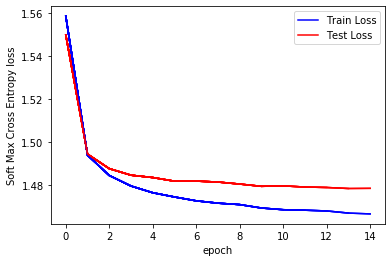

In [25]:
# With BN and Without Dropout
w,c = run_model()

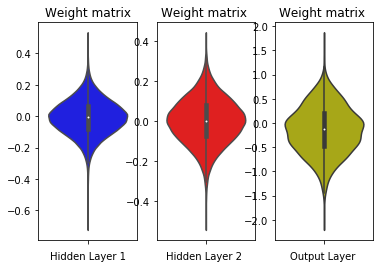

In [26]:
# Plot weight distriubtion at the end of training.
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)

fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

In [46]:
# "Model","No of Layers","No of Units","Activation","Accuracy"
table.add_row(["BN & No Dropout",2,"[784,256,256,10]",0.98])
print(table)

+--------------------+---------------------+------------------+----------+
|       Model        | No of Hidden Layers |   No of Units    | Accuracy |
+--------------------+---------------------+------------------+----------+
| No BN & No Dropout |          2          | [784,256,256,10] |   0.97   |
|  BN & No Dropout   |          2          | [784,256,256,10] |   0.98   |
+--------------------+---------------------+------------------+----------+


Epoch: 0001 train cost=1.759903436 test cost=1.657631977
Epoch: 0002 train cost=1.582765761 test cost=1.533581437
Epoch: 0003 train cost=1.552725868 test cost=1.516168935
Epoch: 0004 train cost=1.535371889 test cost=1.507832254
Epoch: 0005 train cost=1.526957184 test cost=1.503152479
Epoch: 0006 train cost=1.519619572 test cost=1.498384231
Epoch: 0007 train cost=1.514480329 test cost=1.495229675
Epoch: 0008 train cost=1.511001006 test cost=1.493295799
Epoch: 0009 train cost=1.508342153 test cost=1.491744414
Epoch: 0010 train cost=1.505548809 test cost=1.490057549
Epoch: 0011 train cost=1.503413466 test cost=1.488765062
Epoch: 0012 train cost=1.501725340 test cost=1.488661042
Epoch: 0013 train cost=1.500776122 test cost=1.487625888
Epoch: 0014 train cost=1.499179063 test cost=1.487094166
Epoch: 0015 train cost=1.496562637 test cost=1.486118458
Accuracy: 0.9667


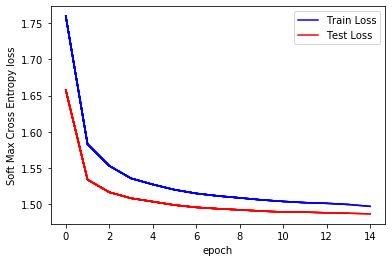

In [71]:
# Without BN and With Dropout
w,c = run_model()

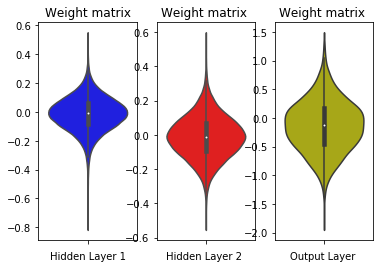

In [72]:
# Plot weight distriubtion at the end of training.
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)

fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

In [74]:
# "Model","No of Layers","No of Units","Activation","Accuracy"
table.add_row(["No BN & Dropout",2,"[784,256,256,10]",0.96])
print(table)

+--------------------+---------------------+------------------+----------+
|       Model        | No of Hidden Layers |   No of Units    | Accuracy |
+--------------------+---------------------+------------------+----------+
| No BN & No Dropout |          2          | [784,256,256,10] |   0.97   |
|  BN & No Dropout   |          2          | [784,256,256,10] |   0.98   |
|  No BN & Dropout   |          2          | [784,256,256,10] |   0.96   |
+--------------------+---------------------+------------------+----------+


Epoch: 0001 train cost=1.690725416 test cost=1.615356161
Epoch: 0002 train cost=1.565698045 test cost=1.520944096
Epoch: 0003 train cost=1.544162516 test cost=1.508412771
Epoch: 0004 train cost=1.531726814 test cost=1.502059145
Epoch: 0005 train cost=1.524816981 test cost=1.496960920
Epoch: 0006 train cost=1.518074628 test cost=1.493297059
Epoch: 0007 train cost=1.512760148 test cost=1.490948573
Epoch: 0008 train cost=1.509534764 test cost=1.488903993
Epoch: 0009 train cost=1.506565269 test cost=1.486767072
Epoch: 0010 train cost=1.502722313 test cost=1.485075052
Epoch: 0011 train cost=1.499809036 test cost=1.483703831
Epoch: 0012 train cost=1.498365546 test cost=1.482924277
Epoch: 0013 train cost=1.496802299 test cost=1.482756910
Epoch: 0014 train cost=1.495493095 test cost=1.481520048
Epoch: 0015 train cost=1.494422861 test cost=1.481174957
Accuracy: 0.9757


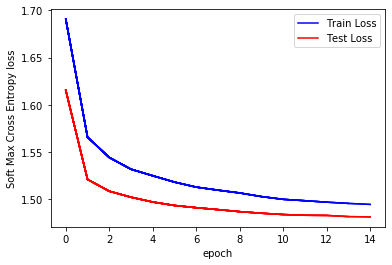

In [85]:
# With BN and With Dropout
w,c = run_model()

In [87]:
# "Model","No of Layers","No of Units","Activation","Accuracy"
table.add_row(["BN & Dropout",2,"[784,256,256,10]",0.97])
print(table)

+--------------------+---------------------+------------------+----------+
|       Model        | No of Hidden Layers |   No of Units    | Accuracy |
+--------------------+---------------------+------------------+----------+
| No BN & No Dropout |          2          | [784,256,256,10] |   0.97   |
|  BN & No Dropout   |          2          | [784,256,256,10] |   0.98   |
|  No BN & Dropout   |          2          | [784,256,256,10] |   0.96   |
|    BN & Dropout    |          2          | [784,256,256,10] |   0.97   |
+--------------------+---------------------+------------------+----------+


In [86]:
# 3 Layer MLP 

In [131]:
# Network Parameters
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_hidden_3 = 128 # 3rd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [132]:
x = tf.placeholder(tf.float32, [None, n_input])
y_ = tf.placeholder(tf.float32, [None, n_classes])

keep_prob = tf.placeholder(tf.float32)
keep_prob_input = tf.placeholder(tf.float32)

In [133]:
# Weight initialization
# He Normal initialization.
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],
                            stddev=(2/(n_hidden_1+1))**0.5, mean=0)),
    
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],
                            stddev=(2/(n_hidden_2+1))**0.5, mean=0)),
    
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],
                            stddev=(2/(n_hidden_3+1))**0.5, mean=0)),
    
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes],
                            stddev=(2/(n_classes+1))**0.5, mean=0))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [134]:
# Model 2
use_batchNorm, use_dropOut = True, True   # WE have to keep changing these switches
epsilon = 1e-3

print( 'x:', x.get_shape(), 'W[h1]:', weights_relu['h1'].get_shape(), 
                              'b[h1]:', biases['b1'].get_shape())

# Hidden layer with Relu activation
layer_1 = tf.add(tf.matmul(x, weights_relu['h1']), biases['b1'])    

if use_batchNorm:
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, 
                                        beta_1, scale_1, epsilon)
layer_1 = tf.nn.relu(layer_1)
if use_dropOut:
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    
print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights_relu['h2'].get_shape(),
                              'b[h2]:', biases['b2'].get_shape()) 

# Hidden layer with Relu activation
layer_2 = tf.add(tf.matmul(layer_1, weights_relu['h2']), biases['b2'])
if use_batchNorm:
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, 
                                        beta_2, scale_2, epsilon)

layer_2 = tf.nn.relu(layer_2)
if use_dropOut:
    layer_2 = tf.nn.dropout(layer_2, keep_prob)
    
print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights_relu['h3'].get_shape(),
                              'b3:', biases['b3'].get_shape())

layer_3 = tf.add(tf.matmul(layer_2, weights_relu['h3']), biases['b3'])
if use_batchNorm:
    batch_mean_3, batch_var_3 = tf.nn.moments(layer_3, [0])
    scale_3 = tf.Variable(tf.ones([n_hidden_3]))
    beta_3 = tf.Variable(tf.zeros([n_hidden_3]))
    layer_3 = tf.nn.batch_normalization(layer_3, batch_mean_3, batch_var_3, 
                                        beta_3, scale_3, epsilon)

layer_3 = tf.nn.relu(layer_3)
if use_dropOut:
    layer_3 = tf.nn.dropout(layer_3, keep_prob)
    
print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights_relu['out'].get_shape(),
                              'b3:', biases['out'].get_shape())

# Output layer with Sigmoid activation
out_layer = tf.matmul(layer_3, weights_relu['out']) + biases['out']
out_layer = tf.nn.sigmoid(out_layer)
print('out_layer:',out_layer.get_shape())

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b3: (128,)
layer_3: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)


In [135]:
# set up cost and optimizer

cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = out_layer, labels = y_))
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

In [136]:
def run_model():
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        fig,ax = plt.subplots(1,1)
        ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
        xs, ytrs, ytes = [], [], []
        for epoch in range(training_epochs):
            train_avg_cost = 0.
            test_avg_cost = 0.
            total_batch = int(mnist_data.train.num_examples/batch_size)

            # Loop over all batches
            for i in range(total_batch):
                batch_xs, batch_ys = mnist_data.train.next_batch(batch_size)

                # here we use AdamOptimizer
                _, c, w = sess.run([optimizer_adam, cost_sgd,weights_relu], 
                                   feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
                train_avg_cost += c / total_batch
                c = sess.run(cost_sgd, feed_dict={x: mnist_data.test.images, 
                                              y_: mnist_data.test.labels,  keep_prob: 1.0})
                test_avg_cost += c / total_batch

            xs.append(epoch)
            ytrs.append(train_avg_cost)
            ytes.append(test_avg_cost)
            plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),fig, 
                            "input-relu(512)-relu(256)-relu(128)-sigmoid(output)-AdamOptimizer")

            if epoch%display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost),
                                                  "test cost={:.9f}".format(test_avg_cost))
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),fig,
                            "input-relu(512)-relu(256)-relu(128)-sigmoid(output)-AdamOptimizer")

        # we are calculating the final accuracy on the test data
        correct_prediction = tf.equal(tf.argmax(out_layer,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print("Accuracy:", accuracy.eval({x: mnist_data.test.images, 
                                  y_: mnist_data.test.labels, keep_prob: 1.0}))
        return w, c

In [137]:
def plot_weight(w):
    # Plot weight distriubtion at the end of training.
    h1_w = w['h1'].flatten().reshape(-1,1)
    h2_w = w['h2'].flatten().reshape(-1,1)
    h3_w = w['h3'].flatten().reshape(-1,1)
    out_w = w['out'].flatten().reshape(-1,1)

    fig = plt.figure()
    plt.subplot(1, 4, 1)
    plt.title("Weight matrix")
    ax = sns.violinplot(y=h1_w,color='b')
    plt.xlabel('Hidden Layer 1')

    plt.subplot(1, 4, 2)
    plt.title("Weight matrix ")
    ax = sns.violinplot(y=h2_w, color='r')
    plt.xlabel('Hidden Layer 2 ')

    plt.subplot(1, 4, 3)
    plt.title("Weight matrix ")
    ax = sns.violinplot(y=h3_w,color='y')
    plt.xlabel('Output Layer ')
    
    plt.subplot(1, 4, 4)
    plt.title("Weight matrix ")
    ax = sns.violinplot(y=out_w,color='y')
    plt.xlabel('Output Layer ')
    plt.show()

Epoch: 0001 train cost=1.724415028 test cost=1.725089503
Epoch: 0002 train cost=1.659226547 test cost=1.665297671
Epoch: 0003 train cost=1.652102614 test cost=1.657444872
Epoch: 0004 train cost=1.645525534 test cost=1.653770006
Epoch: 0005 train cost=1.644605266 test cost=1.652141756
Epoch: 0006 train cost=1.640791462 test cost=1.651228265
Epoch: 0007 train cost=1.642705981 test cost=1.651835701
Epoch: 0008 train cost=1.639625619 test cost=1.649619522
Epoch: 0009 train cost=1.639511052 test cost=1.648886293
Epoch: 0010 train cost=1.638805584 test cost=1.648827449
Epoch: 0011 train cost=1.637063793 test cost=1.647981633
Epoch: 0012 train cost=1.634926372 test cost=1.648139446
Epoch: 0013 train cost=1.637360113 test cost=1.647825703
Epoch: 0014 train cost=1.636315347 test cost=1.647731843
Epoch: 0015 train cost=1.637297489 test cost=1.648290913
Accuracy: 0.7807


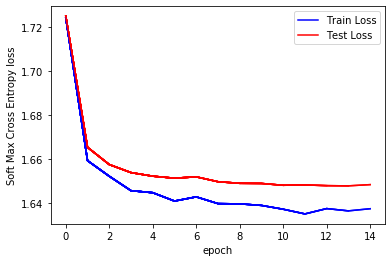

In [105]:
# Without BN and Without Dropout
w,c = run_model()

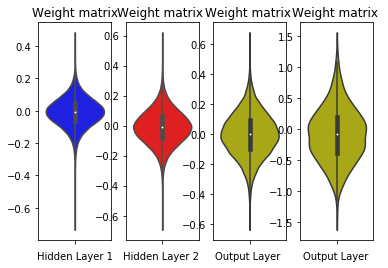

In [106]:
plot_weight(w)

In [107]:
# "Model","No of Layers","No of Units","Accuracy"
table.add_row(["No BN & No Dropout",3,"[784,512,256,128,10]",0.78])
print(table)

+--------------------+---------------------+----------------------+----------+
|       Model        | No of Hidden Layers |     No of Units      | Accuracy |
+--------------------+---------------------+----------------------+----------+
| No BN & No Dropout |          2          |   [784,256,256,10]   |   0.97   |
|  BN & No Dropout   |          2          |   [784,256,256,10]   |   0.98   |
|  No BN & Dropout   |          2          |   [784,256,256,10]   |   0.96   |
|    BN & Dropout    |          2          |   [784,256,256,10]   |   0.97   |
| No BN & No Dropout |          3          | [784,512,256,128,10] |   0.78   |
+--------------------+---------------------+----------------------+----------+


Epoch: 0001 train cost=1.551555210 test cost=1.543841784
Epoch: 0002 train cost=1.487830318 test cost=1.488076750
Epoch: 0003 train cost=1.480044753 test cost=1.482815591
Epoch: 0004 train cost=1.475148520 test cost=1.481060569
Epoch: 0005 train cost=1.473546803 test cost=1.480563408
Epoch: 0006 train cost=1.471222049 test cost=1.479159074
Epoch: 0007 train cost=1.470258818 test cost=1.479168120
Epoch: 0008 train cost=1.469298829 test cost=1.478460877
Epoch: 0009 train cost=1.468701959 test cost=1.478745731
Epoch: 0010 train cost=1.467593025 test cost=1.478216683
Epoch: 0011 train cost=1.467463743 test cost=1.478199854
Epoch: 0012 train cost=1.466641587 test cost=1.477163676
Epoch: 0013 train cost=1.466444323 test cost=1.478065499
Epoch: 0014 train cost=1.465809254 test cost=1.477271322
Epoch: 0015 train cost=1.466594505 test cost=1.477898204
Accuracy: 0.9807


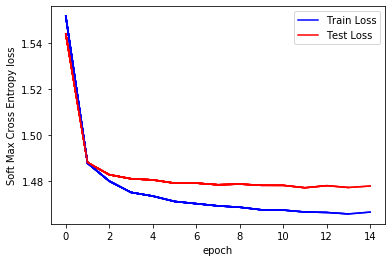

In [115]:
# With BN and Without Dropout
w,c = run_model()

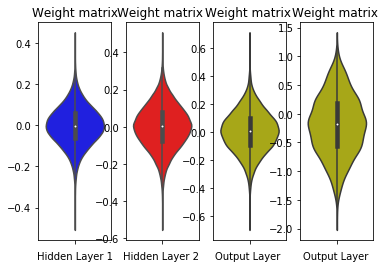

In [116]:
plot_weight(w)

In [120]:
# "Model","No of Layers","No of Units","Accuracy"
table.add_row(["BN & No Dropout",3,"[784,512,256,128,10]",0.98])
print(table)

+--------------------+---------------------+----------------------+----------+
|       Model        | No of Hidden Layers |     No of Units      | Accuracy |
+--------------------+---------------------+----------------------+----------+
| No BN & No Dropout |          2          |   [784,256,256,10]   |   0.97   |
|  BN & No Dropout   |          2          |   [784,256,256,10]   |   0.98   |
|  No BN & Dropout   |          2          |   [784,256,256,10]   |   0.96   |
|    BN & Dropout    |          2          |   [784,256,256,10]   |   0.97   |
| No BN & No Dropout |          3          | [784,512,256,128,10] |   0.78   |
|  BN & No Dropout   |          3          | [784,512,256,128,10] |   0.98   |
+--------------------+---------------------+----------------------+----------+


Epoch: 0001 train cost=1.923547436 test cost=1.777374396
Epoch: 0002 train cost=1.649888306 test cost=1.577592450
Epoch: 0003 train cost=1.594784350 test cost=1.547438501
Epoch: 0004 train cost=1.569458596 test cost=1.531973240
Epoch: 0005 train cost=1.550009896 test cost=1.513707142
Epoch: 0006 train cost=1.537074297 test cost=1.505633482
Epoch: 0007 train cost=1.527585533 test cost=1.500962739
Epoch: 0008 train cost=1.524057899 test cost=1.499139460
Epoch: 0009 train cost=1.518706366 test cost=1.496905099
Epoch: 0010 train cost=1.515258675 test cost=1.494631038
Epoch: 0011 train cost=1.514191138 test cost=1.493741981
Epoch: 0012 train cost=1.512068743 test cost=1.493467327
Epoch: 0013 train cost=1.508987658 test cost=1.491482919
Epoch: 0014 train cost=1.509052733 test cost=1.492746291
Epoch: 0015 train cost=1.507254042 test cost=1.491235861
Accuracy: 0.9598


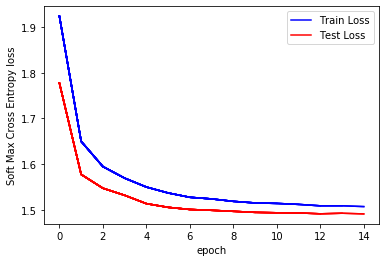

In [128]:
w, c = run_model()

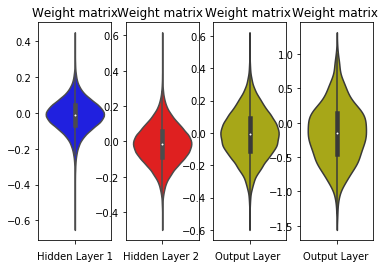

In [129]:
plot_weight(w)

In [130]:
# "Model","No of Layers","No of Units","Accuracy"
table.add_row(["No BN & Dropout",3,"[784,512,256,128,10]",0.95])
print(table)

+--------------------+---------------------+----------------------+----------+
|       Model        | No of Hidden Layers |     No of Units      | Accuracy |
+--------------------+---------------------+----------------------+----------+
| No BN & No Dropout |          2          |   [784,256,256,10]   |   0.97   |
|  BN & No Dropout   |          2          |   [784,256,256,10]   |   0.98   |
|  No BN & Dropout   |          2          |   [784,256,256,10]   |   0.96   |
|    BN & Dropout    |          2          |   [784,256,256,10]   |   0.97   |
| No BN & No Dropout |          3          | [784,512,256,128,10] |   0.78   |
|  BN & No Dropout   |          3          | [784,512,256,128,10] |   0.98   |
|  No BN & Dropout   |          3          | [784,512,256,128,10] |   0.95   |
+--------------------+---------------------+----------------------+----------+


Epoch: 0001 train cost=1.735147609 test cost=1.627619583
Epoch: 0002 train cost=1.565496151 test cost=1.512552367
Epoch: 0003 train cost=1.541189906 test cost=1.500751421
Epoch: 0004 train cost=1.526590909 test cost=1.494708527
Epoch: 0005 train cost=1.517893760 test cost=1.490246117
Epoch: 0006 train cost=1.512601304 test cost=1.487560744
Epoch: 0007 train cost=1.507109816 test cost=1.484684251
Epoch: 0008 train cost=1.503703494 test cost=1.483565541
Epoch: 0009 train cost=1.499799664 test cost=1.482330774
Epoch: 0010 train cost=1.496795461 test cost=1.481065884
Epoch: 0011 train cost=1.495785201 test cost=1.480551332
Epoch: 0012 train cost=1.492922471 test cost=1.479732544
Epoch: 0013 train cost=1.492114149 test cost=1.478903759
Epoch: 0014 train cost=1.490680125 test cost=1.478579580
Epoch: 0015 train cost=1.488233277 test cost=1.478082604
Accuracy: 0.9785


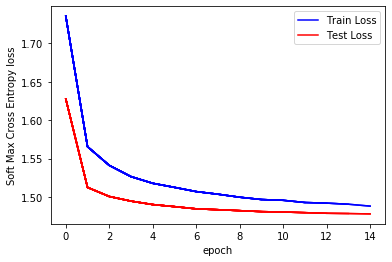

In [138]:
w,c = run_model()

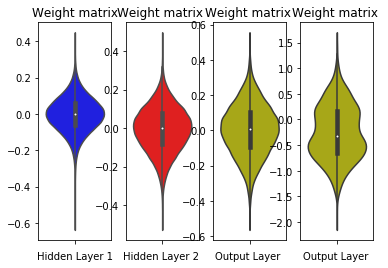

In [139]:
plot_weight(w)

In [140]:
# "Model","No of Layers","No of Units","Accuracy"
table.add_row(["BN & Dropout",3,"[784,512,256,128,10]",0.97])
print(table)

+--------------------+---------------------+----------------------+----------+
|       Model        | No of Hidden Layers |     No of Units      | Accuracy |
+--------------------+---------------------+----------------------+----------+
| No BN & No Dropout |          2          |   [784,256,256,10]   |   0.97   |
|  BN & No Dropout   |          2          |   [784,256,256,10]   |   0.98   |
|  No BN & Dropout   |          2          |   [784,256,256,10]   |   0.96   |
|    BN & Dropout    |          2          |   [784,256,256,10]   |   0.97   |
| No BN & No Dropout |          3          | [784,512,256,128,10] |   0.78   |
|  BN & No Dropout   |          3          | [784,512,256,128,10] |   0.98   |
|  No BN & Dropout   |          3          | [784,512,256,128,10] |   0.95   |
|    BN & Dropout    |          3          | [784,512,256,128,10] |   0.97   |
+--------------------+---------------------+----------------------+----------+


In [141]:
# 5 Layer MLP 

In [49]:
# Network Parameters
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 384 # 2nd layer number of neurons
n_hidden_3 = 256 # 3rd layer number of neurons
n_hidden_4 = 128 # 4th layer number of neurons
n_hidden_5 = 64  # 5th layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [50]:
x = tf.placeholder(tf.float32, [None, n_input])
y_ = tf.placeholder(tf.float32, [None, n_classes])

keep_prob = tf.placeholder(tf.float32)
keep_prob_input = tf.placeholder(tf.float32)

In [51]:
# Weight initialization
# He Normal initialization.
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],
                            stddev=(2/(n_hidden_1+1))**0.5, mean=0)),
    
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],
                            stddev=(2/(n_hidden_2+1))**0.5, mean=0)),
    
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],
                            stddev=(2/(n_hidden_3+1))**0.5, mean=0)),
    
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4],
                            stddev=(2/(n_hidden_4+1))**0.5, mean=0)),
    
    'h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5],
                            stddev=(2/(n_hidden_5+1))**0.5, mean=0)),
    
    'out': tf.Variable(tf.random_normal([n_hidden_5, n_classes],
                            stddev=(2/(n_classes+1))**0.5, mean=0))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'b5': tf.Variable(tf.random_normal([n_hidden_5])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [52]:
# Model 3
use_batchNorm, use_dropOut = False, True   # WE have to keep changing these switches
epsilon = 1e-3

print( 'x:', x.get_shape(), 'W[h1]:', weights_relu['h1'].get_shape(), 
                              'b[h1]:', biases['b1'].get_shape())

# Hidden layer with Relu activation
layer_1 = tf.add(tf.matmul(x, weights_relu['h1']), biases['b1'])    

if use_batchNorm:
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, 
                                        beta_1, scale_1, epsilon)
layer_1 = tf.nn.relu(layer_1)
if use_dropOut:
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    
print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights_relu['h2'].get_shape(),
                              'b[h2]:', biases['b2'].get_shape()) 

# Hidden layer with Relu activation
layer_2 = tf.add(tf.matmul(layer_1, weights_relu['h2']), biases['b2'])
if use_batchNorm:
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, 
                                        beta_2, scale_2, epsilon)

layer_2 = tf.nn.relu(layer_2)
if use_dropOut:
    layer_2 = tf.nn.dropout(layer_2, keep_prob)
    
print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights_relu['h3'].get_shape(),
                              'b[h3]:', biases['b3'].get_shape())

layer_3 = tf.add(tf.matmul(layer_2, weights_relu['h3']), biases['b3'])
if use_batchNorm:
    batch_mean_3, batch_var_3 = tf.nn.moments(layer_3, [0])
    scale_3 = tf.Variable(tf.ones([n_hidden_3]))
    beta_3 = tf.Variable(tf.zeros([n_hidden_3]))
    layer_3 = tf.nn.batch_normalization(layer_3, batch_mean_3, batch_var_3, 
                                        beta_3, scale_3, epsilon)

layer_3 = tf.nn.relu(layer_3)
if use_dropOut:
    layer_3 = tf.nn.dropout(layer_3, keep_prob)
    
print( 'layer_3:', layer_3.get_shape(), 'W[h4]:', weights_relu['h4'].get_shape(),
                              'b[h4]:', biases['b4'].get_shape())

layer_4 = tf.add(tf.matmul(layer_3, weights_relu['h4']), biases['b4'])
if use_batchNorm:
    batch_mean_4, batch_var_4 = tf.nn.moments(layer_4, [0])
    scale_4 = tf.Variable(tf.ones([n_hidden_4]))
    beta_4 = tf.Variable(tf.zeros([n_hidden_4]))
    layer_4 = tf.nn.batch_normalization(layer_4, batch_mean_4, batch_var_4, 
                                        beta_4, scale_4, epsilon)

layer_4 = tf.nn.relu(layer_4)
if use_dropOut:
    layer_4 = tf.nn.dropout(layer_4, keep_prob)
    
print( 'layer_4:', layer_4.get_shape(), 'W[h5]:', weights_relu['h5'].get_shape(),
                              'b[h5]:', biases['b5'].get_shape())

layer_5 = tf.add(tf.matmul(layer_4, weights_relu['h5']), biases['b5'])
if use_batchNorm:
    batch_mean_5, batch_var_5 = tf.nn.moments(layer_5, [0])
    scale_5 = tf.Variable(tf.ones([n_hidden_5]))
    beta_5 = tf.Variable(tf.zeros([n_hidden_5]))
    layer_5 = tf.nn.batch_normalization(layer_5, batch_mean_5, batch_var_5, 
                                        beta_5, scale_5, epsilon)

layer_5 = tf.nn.relu(layer_5)
if use_dropOut:
    layer_5 = tf.nn.dropout(layer_5, keep_prob)
    
print( 'layer_5:', layer_5.get_shape(), 'W[out]:', weights_relu['out'].get_shape(),
                              'b[h5]:', biases['out'].get_shape())

# Output layer with Sigmoid activation
out_layer = tf.matmul(layer_5, weights_relu['out']) + biases['out']
out_layer = tf.nn.sigmoid(out_layer)
print('out_layer:',out_layer.get_shape())

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 384) b[h2]: (384,)
layer_2: (?, 384) W[h3]: (384, 256) b[h3]: (256,)
layer_3: (?, 256) W[h4]: (256, 128) b[h4]: (128,)
layer_4: (?, 128) W[h5]: (128, 64) b[h5]: (64,)
layer_5: (?, 64) W[out]: (64, 10) b[h5]: (10,)
out_layer: (?, 10)


In [53]:
# set up cost and optimizer

cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = out_layer, labels = y_))
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

In [54]:
def run_model():
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        fig,ax = plt.subplots(1,1)
        ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
        xs, ytrs, ytes = [], [], []
        for epoch in range(training_epochs):
            train_avg_cost = 0.
            test_avg_cost = 0.
            total_batch = int(mnist_data.train.num_examples/batch_size)

            # Loop over all batches
            for i in range(total_batch):
                batch_xs, batch_ys = mnist_data.train.next_batch(batch_size)

                # here we use AdamOptimizer
                _, c, w = sess.run([optimizer_adam, cost_sgd,weights_relu], 
                                   feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
                train_avg_cost += c / total_batch
                c = sess.run(cost_sgd, feed_dict={x: mnist_data.test.images, 
                                              y_: mnist_data.test.labels,  keep_prob: 1.0})
                test_avg_cost += c / total_batch

            xs.append(epoch)
            ytrs.append(train_avg_cost)
            ytes.append(test_avg_cost)
            plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),fig, 
                "input-relu(512)-relu(384)-relu(256)-relu(128)-relu(64)-sigmoid(output)-AdamOptimizer")

            if epoch%display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost),
                                                  "test cost={:.9f}".format(test_avg_cost))
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),fig,
                "input-relu(512)-relu(384)-relu(256)-relu(128)-relu(64)-sigmoid(output)-AdamOptimizer")

        # we are calculating the final accuracy on the test data
        correct_prediction = tf.equal(tf.argmax(out_layer,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print("Accuracy:", accuracy.eval({x: mnist_data.test.images, 
                                  y_: mnist_data.test.labels, keep_prob: 1.0}))
        return w, c

In [55]:
def plot_weight(w):
    # Plot weight distriubtion at the end of training.
    h1_w = w['h1'].flatten().reshape(-1,1)
    h2_w = w['h2'].flatten().reshape(-1,1)
    h3_w = w['h3'].flatten().reshape(-1,1)
    h4_w = w['h4'].flatten().reshape(-1,1)
    h5_w = w['h5'].flatten().reshape(-1,1)
    out_w = w['out'].flatten().reshape(-1,1)

    fig = plt.figure()
    plt.subplot(1, 6, 1)
    plt.title("Weight matrix")
    ax = sns.violinplot(y=h1_w,color='b')
    plt.xlabel('Hidden Layer 1')

    plt.subplot(1, 6, 2)
    plt.title("Weight matrix ")
    ax = sns.violinplot(y=h2_w, color='r')
    plt.xlabel('Hidden Layer 2 ')

    plt.subplot(1, 6, 3)
    plt.title("Weight matrix ")
    ax = sns.violinplot(y=h3_w,color='y')
    plt.xlabel('Output Layer ')
    
    plt.subplot(1, 6, 4)
    plt.title("Weight matrix ")
    ax = sns.violinplot(y=h4_w,color='y')
    plt.xlabel('Output Layer ')
    
    plt.subplot(1, 6, 5)
    plt.title("Weight matrix ")
    ax = sns.violinplot(y=h5_w,color='y')
    plt.xlabel('Output Layer ')
    
    plt.subplot(1, 6, 6)
    plt.title("Weight matrix ")
    ax = sns.violinplot(y=out_w,color='y')
    plt.xlabel('Output Layer ')
    plt.show()

Epoch: 0001 train cost=1.666388924 test cost=1.664768569
Epoch: 0002 train cost=1.584407962 test cost=1.584915396
Epoch: 0003 train cost=1.576518192 test cost=1.578678144
Epoch: 0004 train cost=1.570174091 test cost=1.574943084
Epoch: 0005 train cost=1.570907821 test cost=1.573335734
Epoch: 0006 train cost=1.565126382 test cost=1.571309181
Epoch: 0007 train cost=1.569327874 test cost=1.572164182
Epoch: 0008 train cost=1.568363352 test cost=1.572397860
Epoch: 0009 train cost=1.570808167 test cost=1.575564265
Epoch: 0010 train cost=1.570558932 test cost=1.575461745
Epoch: 0011 train cost=1.565854115 test cost=1.570420797
Epoch: 0012 train cost=1.568019303 test cost=1.574033220
Epoch: 0013 train cost=1.570836614 test cost=1.575691985
Epoch: 0014 train cost=1.569169731 test cost=1.573997481
Epoch: 0015 train cost=1.572603820 test cost=1.576607630
Accuracy: 0.8584


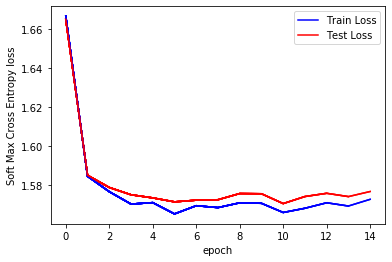

In [153]:
# Without BN and Without Dropout
w,c = run_model()

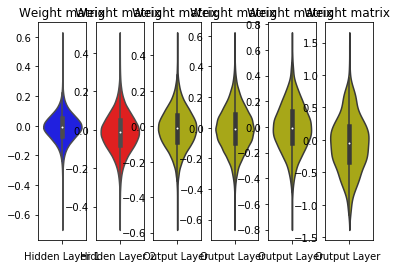

In [154]:
plot_weight(w)

In [155]:
# "Model","No of Layers","No of Units","Accuracy"
table.add_row(["No BN & No Dropout",5,"[784,384,512,256,128,64,10]",0.85])
print(table)

+--------------------+---------------------+-----------------------------+----------+
|       Model        | No of Hidden Layers |         No of Units         | Accuracy |
+--------------------+---------------------+-----------------------------+----------+
| No BN & No Dropout |          2          |       [784,256,256,10]      |   0.97   |
|  BN & No Dropout   |          2          |       [784,256,256,10]      |   0.98   |
|  No BN & Dropout   |          2          |       [784,256,256,10]      |   0.96   |
|    BN & Dropout    |          2          |       [784,256,256,10]      |   0.97   |
| No BN & No Dropout |          3          |     [784,512,256,128,10]    |   0.78   |
|  BN & No Dropout   |          3          |     [784,512,256,128,10]    |   0.98   |
|  No BN & Dropout   |          3          |     [784,512,256,128,10]    |   0.95   |
|    BN & Dropout    |          3          |     [784,512,256,128,10]    |   0.97   |
| No BN & No Dropout |          5          | [784,384,

Epoch: 0001 train cost=1.572831467 test cost=1.564109642
Epoch: 0002 train cost=1.488379573 test cost=1.487347141
Epoch: 0003 train cost=1.480788367 test cost=1.482998726
Epoch: 0004 train cost=1.476273555 test cost=1.480205759
Epoch: 0005 train cost=1.473853672 test cost=1.479110637
Epoch: 0006 train cost=1.471989698 test cost=1.478369296
Epoch: 0007 train cost=1.470287845 test cost=1.477342008
Epoch: 0008 train cost=1.470725852 test cost=1.478051731
Epoch: 0009 train cost=1.469680078 test cost=1.478038399
Epoch: 0010 train cost=1.468082133 test cost=1.476221145
Epoch: 0011 train cost=1.468418921 test cost=1.476566579
Epoch: 0012 train cost=1.467979412 test cost=1.476099741
Epoch: 0013 train cost=1.466876512 test cost=1.475988147
Epoch: 0014 train cost=1.466847590 test cost=1.476136869
Epoch: 0015 train cost=1.466201833 test cost=1.475974899
Accuracy: 0.9822


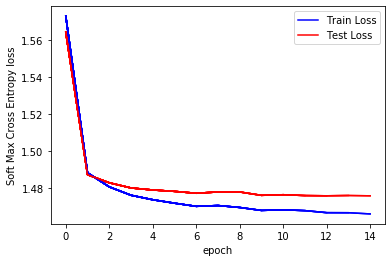

In [163]:
# With BN and Without Dropout
w,c = run_model()

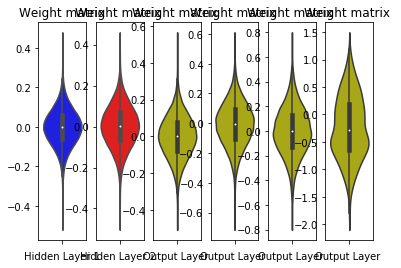

In [164]:
plot_weight(w)

In [165]:
# "Model","No of Layers","No of Units","Accuracy"
table.add_row(["BN & No Dropout",5,"[784,384,512,256,128,64,10]",0.98])
print(table)

+--------------------+---------------------+-----------------------------+----------+
|       Model        | No of Hidden Layers |         No of Units         | Accuracy |
+--------------------+---------------------+-----------------------------+----------+
| No BN & No Dropout |          2          |       [784,256,256,10]      |   0.97   |
|  BN & No Dropout   |          2          |       [784,256,256,10]      |   0.98   |
|  No BN & Dropout   |          2          |       [784,256,256,10]      |   0.96   |
|    BN & Dropout    |          2          |       [784,256,256,10]      |   0.97   |
| No BN & No Dropout |          3          |     [784,512,256,128,10]    |   0.78   |
|  BN & No Dropout   |          3          |     [784,512,256,128,10]    |   0.98   |
|  No BN & Dropout   |          3          |     [784,512,256,128,10]    |   0.95   |
|    BN & Dropout    |          3          |     [784,512,256,128,10]    |   0.97   |
| No BN & No Dropout |          5          | [784,384,

Epoch: 0001 train cost=2.354361770 test cost=2.321973105
Epoch: 0002 train cost=2.317582014 test cost=2.302601576
Epoch: 0003 train cost=2.310513624 test cost=2.302601576
Epoch: 0004 train cost=2.306676997 test cost=2.302601576
Epoch: 0005 train cost=2.305071158 test cost=2.302601576
Epoch: 0006 train cost=2.303673732 test cost=2.302601576
Epoch: 0007 train cost=2.303841054 test cost=2.302601576
Epoch: 0008 train cost=2.303264282 test cost=2.302601576
Epoch: 0009 train cost=2.303260448 test cost=2.302601576
Epoch: 0010 train cost=2.302998356 test cost=2.302601576
Epoch: 0011 train cost=2.302923910 test cost=2.302601576
Epoch: 0012 train cost=2.303382092 test cost=2.302601576
Epoch: 0013 train cost=2.302851424 test cost=2.302601576
Epoch: 0014 train cost=2.302882841 test cost=2.302601576
Epoch: 0015 train cost=2.303055505 test cost=2.302601576
Accuracy: 0.098


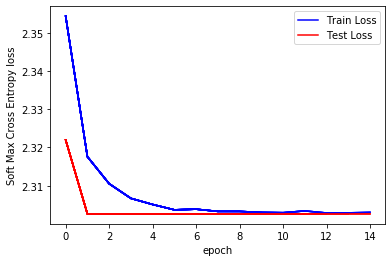

In [56]:
# No BN and With Dropout
w,c = run_model()

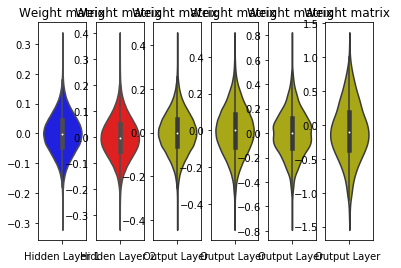

In [17]:
plot_weight(w)

In [29]:
# "Model","No of Layers","No of Units","Accuracy"
table.add_row(["No BN & Dropout",5,"[784,384,512,256,128,64,10]",0.098])
print(table)

+--------------------+---------------------+-----------------------------+----------+
|       Model        | No of Hidden Layers |         No of Units         | Accuracy |
+--------------------+---------------------+-----------------------------+----------+
| No BN & No Dropout |          2          |       [784,256,256,10]      |   0.97   |
|  BN & No Dropout   |          2          |       [784,256,256,10]      |   0.98   |
|  No BN & Dropout   |          2          |       [784,256,256,10]      |   0.96   |
|    BN & Dropout    |          2          |       [784,256,256,10]      |   0.97   |
| No BN & No Dropout |          3          |     [784,512,256,128,10]    |   0.78   |
|  BN & No Dropout   |          3          |     [784,512,256,128,10]    |   0.98   |
|  No BN & Dropout   |          3          |     [784,512,256,128,10]    |   0.95   |
|    BN & Dropout    |          3          |     [784,512,256,128,10]    |   0.97   |
| No BN & No Dropout |          5          | [784,384,

Epoch: 0001 train cost=1.954594129 test cost=1.764196298
Epoch: 0002 train cost=1.644420621 test cost=1.547594223
Epoch: 0003 train cost=1.592272512 test cost=1.527866930
Epoch: 0004 train cost=1.570611747 test cost=1.521848925
Epoch: 0005 train cost=1.556867586 test cost=1.518750438
Epoch: 0006 train cost=1.549666221 test cost=1.515069666
Epoch: 0007 train cost=1.542048534 test cost=1.506556306
Epoch: 0008 train cost=1.529550910 test cost=1.494383340
Epoch: 0009 train cost=1.519507929 test cost=1.487945196
Epoch: 0010 train cost=1.516298204 test cost=1.487287529
Epoch: 0011 train cost=1.511072840 test cost=1.485856568
Epoch: 0012 train cost=1.508224884 test cost=1.485102043
Epoch: 0013 train cost=1.507137326 test cost=1.483881110
Epoch: 0014 train cost=1.505805542 test cost=1.483576352
Epoch: 0015 train cost=1.503525722 test cost=1.482891660
Accuracy: 0.975


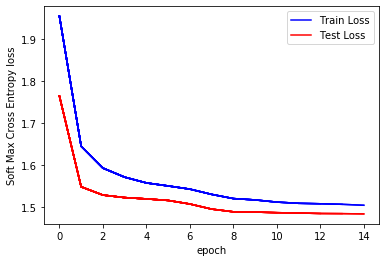

In [37]:
# With BN and With Dropout
w,c = run_model()

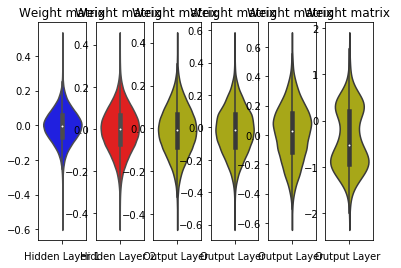

In [38]:
plot_weight(w)

In [39]:
# "Model","No of Layers","No of Units","Accuracy"
table.add_row(["BN & Dropout",5,"[784,384,512,256,128,64,10]",0.97])
print(table)

+--------------------+---------------------+-----------------------------+----------+
|       Model        | No of Hidden Layers |         No of Units         | Accuracy |
+--------------------+---------------------+-----------------------------+----------+
| No BN & No Dropout |          2          |       [784,256,256,10]      |   0.97   |
|  BN & No Dropout   |          2          |       [784,256,256,10]      |   0.98   |
|  No BN & Dropout   |          2          |       [784,256,256,10]      |   0.96   |
|    BN & Dropout    |          2          |       [784,256,256,10]      |   0.97   |
| No BN & No Dropout |          3          |     [784,512,256,128,10]    |   0.78   |
|  BN & No Dropout   |          3          |     [784,512,256,128,10]    |   0.98   |
|  No BN & Dropout   |          3          |     [784,512,256,128,10]    |   0.95   |
|    BN & Dropout    |          3          |     [784,512,256,128,10]    |   0.97   |
| No BN & No Dropout |          5          | [784,384,

In [57]:
# Conclusions